El cálculo de la penalización por energía reactiva se realiza de la siguiente manera:
ER (penalización)= ERi-30%(EAFP+EAHP)
Donde:
ERi=Energía reactiva inductiva
EAFP=energía activa fuera de punta
EAHP= energía activa presente hora de punta
Consideraciones:
•	Se aplica sólo cuando ER=>0
•	Para el cálculo la medición debe estar en unidad de energías: KWH, KVARH
La energía activa y reactiva en hora de punta y fuera de punta se calcula como la suma durante el día:
•	∑EA en Hora Punta 18:00 hasta 23:00hrs,
•	∑EA en Fuera de Punta: 00:00 a 17.59hrs y 23:01 hasta 24:00hrs
Costo promedio está en 0.0531 Soles por kVarh

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
archivos= []
rango = range(1, 31, 1)
for i in rango:
    nombre = "DATOSCLIENTE" + str(i) + '.csv'
    archivos.append(nombre)

for i in range(len(archivos)):
    url= 'https://raw.githubusercontent.com/Pacheco-Carvajal/GPA-Data-ElectroDunas/main/' + archivos[i]
    temp = pd.read_csv(url)
    temp['idCliente'] = i + 1
    if i == 0:
        clientes = temp.copy()
    else:
        clientes = pd.concat([clientes, temp])
clientes

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,idCliente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1
...,...,...,...,...,...,...
11410,2022-04-21 10:00:00,0.960105,0.473234,1273.150602,1027.084539,30
11411,2022-04-21 11:00:00,0.624300,0.699936,1063.524968,1205.829819,30
11412,2022-04-21 12:00:00,0.985633,0.123560,1207.284283,1127.893714,30
11413,2022-04-21 13:00:00,0.710436,0.399262,1205.012971,1090.835898,30


In [3]:
clientes.to_csv('DATOS_CLIENTES_CONSOLIDADO')

In [3]:
clientes['Fecha'] = pd.to_datetime(clientes['Fecha'])
clientes['Mes'] = clientes['Fecha'].dt.month
clientes['Año'] = clientes['Fecha'].dt.year
clientes['Año_Mes'] = clientes['Fecha'].dt.to_period('M')
clientes = clientes[~(clientes['Año_Mes'] == '2023-04')]
clientes['Hora'] = clientes.Fecha.dt.hour
clientes.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,idCliente,Mes,Año,Año_Mes,Hora
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,1,2021,2021-01,0
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,1,2021,2021-01,1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,1,2021,2021-01,2
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,1,2021,2021-01,3
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,1,2021,2021-01,4


In [4]:
def conditions(clientes):
    if (clientes.Hora >= 18) & (clientes.Hora <= 23):
        return 'Hora Pico'
    else:
        return 'Hora Valle'

clientes['Tipo_hora'] = clientes.apply(conditions, axis=1)
clientes.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,idCliente,Mes,Año,Año_Mes,Hora,Tipo_hora
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,1,2021,2021-01,0,Hora Valle
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,1,2021,2021-01,1,Hora Valle
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,1,2021,2021-01,2,Hora Valle
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,1,2021,2021-01,3,Hora Valle
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,1,2021,2021-01,4,Hora Valle


El número óptimo de clústeres es: 3


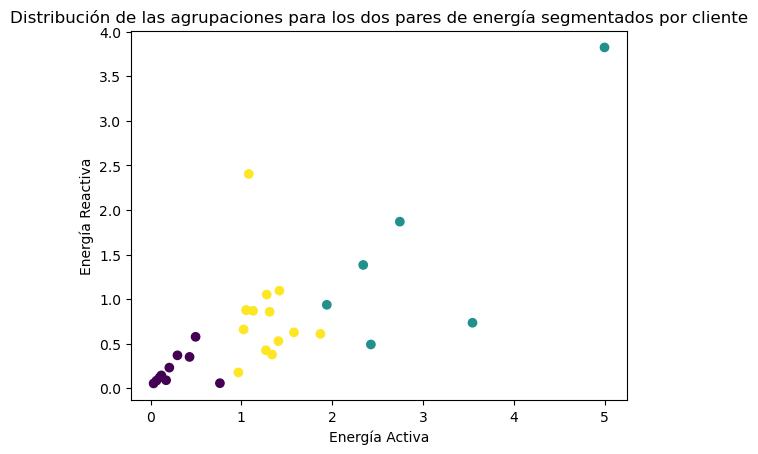

In [13]:
# Seleccionar las columnas relevantes para el clustering
df = clientes[['Active_energy',
               'Reactive_energy',
               'idCliente']].groupby('idCliente').mean().reset_index()
X = df[['Active_energy', 'Reactive_energy']]

# Encontrar el número óptimo de clústeres utilizando el Coeficiente de Silhouette
silhouette_scores = []
possible_k_values = range(2, 21)
for k in possible_k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=123)
    cluster_labels = kmedoids.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Definir el número óptimo de clústeres
optimal_k = possible_k_values[np.argmax(silhouette_scores)]
print(f'El número óptimo de clústeres es: {optimal_k}')

# Aplicar K-medoides
kmedoids = KMedoids(n_clusters=optimal_k, random_state=123)
df['Cluster'] = kmedoids.fit_predict(X)

# Gráfica de la distribución de las agrupaciones
plt.scatter(df['Active_energy'], df['Reactive_energy'], c=df['Cluster'], cmap='viridis')
plt.title('Distribución de las agrupaciones para los dos pares de energía segmentados por cliente')
plt.xlabel('Energía Activa')
plt.ylabel('Energía Reactiva')
plt.show()

In [8]:
df.Cluster.value_counts()

Cluster
2    14
0    10
1     6
Name: count, dtype: int64

In [20]:
df[df.Cluster == 1]

,idCliente,Active_energy,Reactive_energy,Cluster
0,1,1.940851,0.935563,1
1,2,2.745103,1.868575,1
2,3,2.341736,1.382780,1
4,5,4.998855,3.823699,1
6,7,2.426171,0.490630,1
9,10,3.545099,0.734211,1


In [14]:
df[df.Cluster == 2]

,idCliente,Active_energy,Reactive_energy,Cluster
3,4,1.270291,0.425386,2
5,6,1.407554,0.528432,2
7,8,1.579518,0.626147,2
11,12,1.054128,0.875560,2
12,13,0.967254,0.176584,2
15,16,1.311767,0.857154,2
16,17,1.279278,1.050864,2
17,18,1.418947,1.093954,2
18,19,1.129092,0.868370,2
19,20,1.081665,2.403926,2


El número óptimo de clústeres es: 2


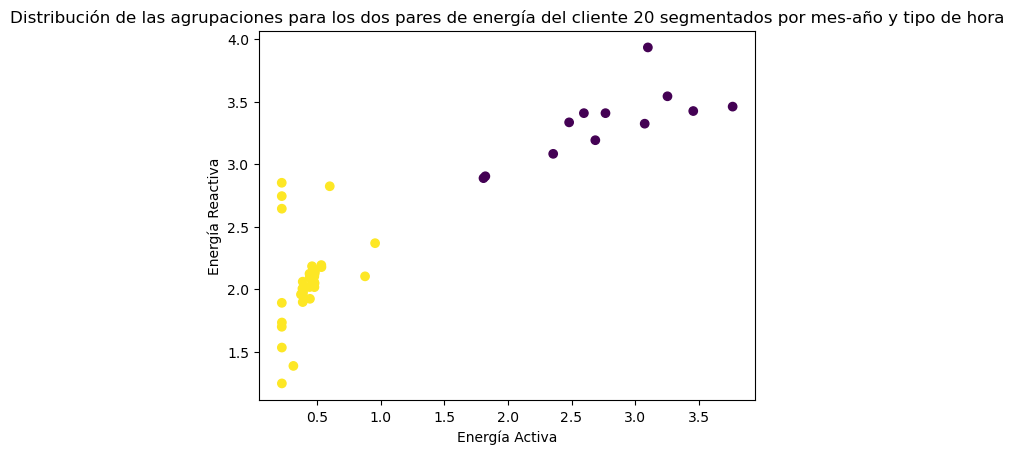

In [29]:
# Seleccionar las columnas relevantes para el clustering
i = 20
df = clientes[clientes.idCliente == i]
df = df[['Active_energy',
         'Reactive_energy',
         'idCliente',
         'Año_Mes',
         'Tipo_hora']].groupby(['idCliente', 'Año_Mes', 'Tipo_hora']).mean().reset_index()
X = df[['Active_energy', 'Reactive_energy']]

# Encontrar el número óptimo de clústeres utilizando el Coeficiente de Silhouette
silhouette_scores = []
possible_k_values = range(2, 21)
for k in possible_k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=123)
    cluster_labels = kmedoids.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Definir el número óptimo de clústeres
optimal_k = possible_k_values[np.argmax(silhouette_scores)]
print(f'El número óptimo de clústeres es: {optimal_k}')

# Aplicar K-medoides
kmedoids = KMedoids(n_clusters=optimal_k, random_state=123)
df['Cluster'] = kmedoids.fit_predict(X)

# Gráfica de la distribución de las agrupaciones
plt.scatter(df['Active_energy'], df['Reactive_energy'], c=df['Cluster'], cmap='viridis')
plt.title(f'Distribución de las agrupaciones para los dos pares de energía del cliente {i} segmentados por mes-año y tipo de hora')
plt.xlabel('Energía Activa')
plt.ylabel('Energía Reactiva')
plt.show()

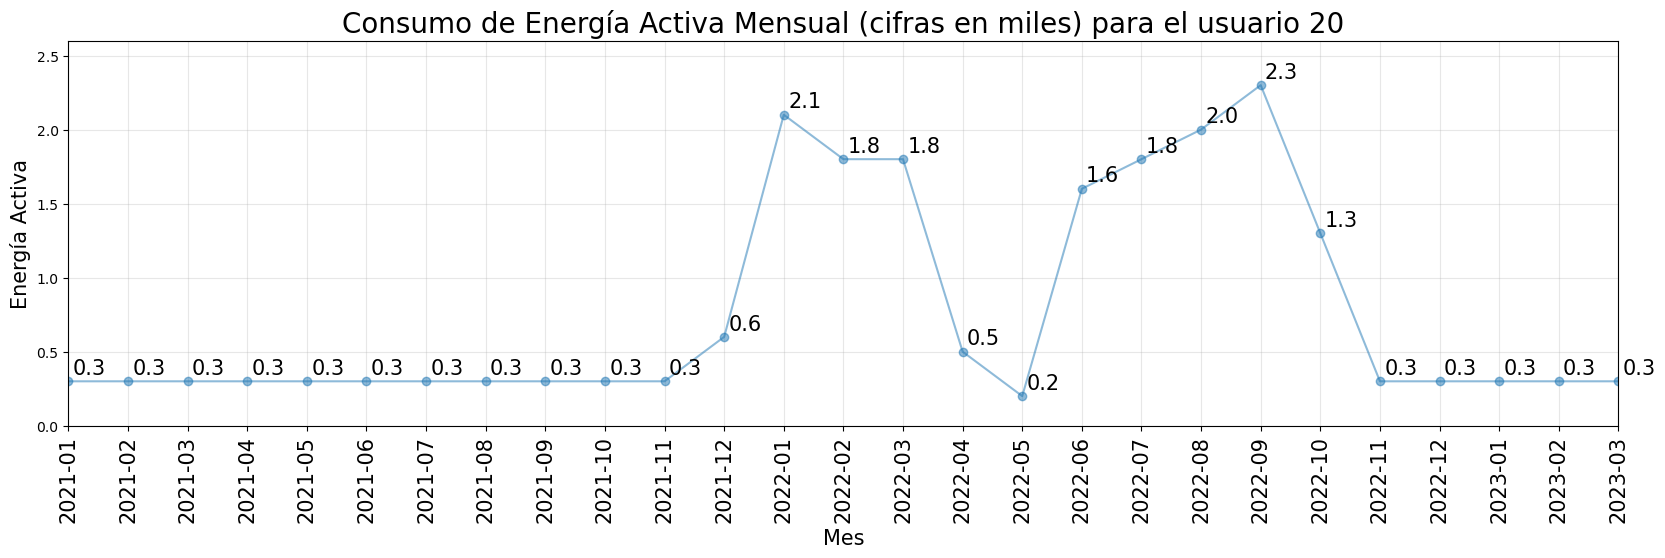

In [30]:
energia = clientes[clientes.idCliente == 20]
energia = energia[['Active_energy', 'Año_Mes']].groupby('Año_Mes').sum().reset_index()
energia['Active_energy'] = round(energia['Active_energy'] / 1e3, 1)

ax = energia.plot(x='Año_Mes', y='Active_energy', legend=False, figsize=(20, 5), marker='o', alpha=0.5)
for i, txt in enumerate(energia['Active_energy']):
    ax.annotate(txt,
                (energia['Año_Mes'].iloc[i], energia['Active_energy'].iloc[i]),
                textcoords="offset points",
                xytext=(15,5),
                ha='center',
                fontsize=15)
ax.set_xticks(energia['Año_Mes'])
ax.set_xticklabels(energia['Año_Mes'], fontsize=15, rotation=90)
ax.set_ylim(0, max(energia['Active_energy']) + energia['Active_energy'].quantile(0.1))
plt.title('Consumo de Energía Activa Mensual (cifras en miles) para el usuario 20', fontsize=20)
plt.xlabel('Mes', fontsize=15)
plt.ylabel('Energía Activa', fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

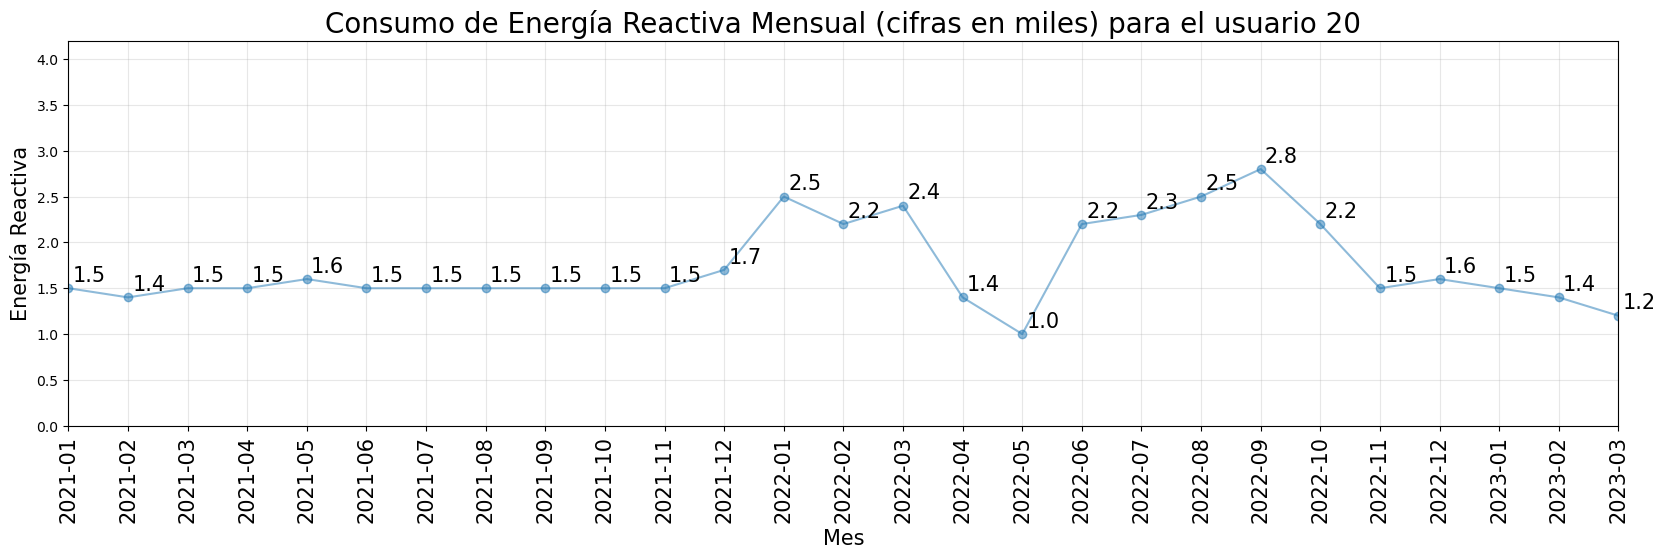

In [31]:
energia = clientes[clientes.idCliente == 20]
energia = energia[['Reactive_energy', 'Año_Mes']].groupby('Año_Mes').sum().reset_index()
energia['Reactive_energy'] = round(energia['Reactive_energy'] / 1e3, 1)

ax = energia.plot(x='Año_Mes', y='Reactive_energy', legend=False, figsize=(20, 5), marker='o', alpha=0.5)
for i, txt in enumerate(energia['Reactive_energy']):
    ax.annotate(txt,
                (energia['Año_Mes'].iloc[i], energia['Reactive_energy'].iloc[i]),
                textcoords="offset points",
                xytext=(15,5),
                ha='center',
                fontsize=15)
ax.set_xticks(energia['Año_Mes'])
ax.set_xticklabels(energia['Año_Mes'], fontsize=15, rotation=90)
ax.set_ylim(0, max(energia['Reactive_energy']) + energia['Reactive_energy'].quantile(0.1))
plt.title('Consumo de Energía Reactiva Mensual (cifras en miles) para el usuario 20', fontsize=20)
plt.xlabel('Mes', fontsize=15)
plt.ylabel('Energía Reactiva', fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

El número óptimo de clústeres es: 2


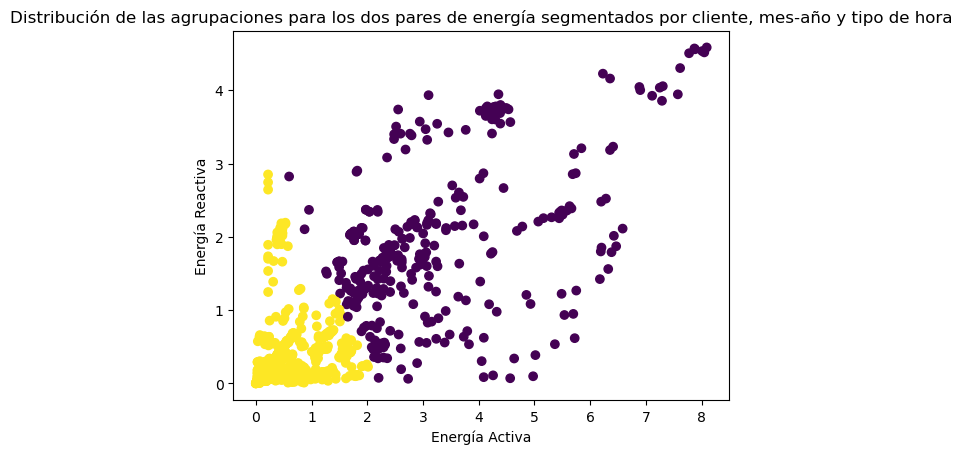

In [6]:
# Seleccionar las columnas relevantes para el clustering
df = clientes[['Active_energy',
               'Reactive_energy',
               'idCliente',
               'Año_Mes',
               'Tipo_hora']].groupby(['idCliente', 'Año_Mes', 'Tipo_hora']).mean().reset_index()
X = df[['Active_energy', 'Reactive_energy']]

# Encontrar el número óptimo de clústeres utilizando el Coeficiente de Silhouette
silhouette_scores = []
possible_k_values = range(2, 21)
for k in possible_k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=123)
    cluster_labels = kmedoids.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Definir el número óptimo de clústeres
optimal_k = possible_k_values[np.argmax(silhouette_scores)]
print(f'El número óptimo de clústeres es: {optimal_k}')

# Aplicar K-medoides
kmedoids = KMedoids(n_clusters=optimal_k, random_state=123)
df['Cluster'] = kmedoids.fit_predict(X)

# Gráfica de la distribución de las agrupaciones
plt.scatter(df['Active_energy'], df['Reactive_energy'], c=df['Cluster'], cmap='viridis')
plt.title('Distribución de las agrupaciones para los dos pares de energía segmentados por cliente, mes-año y tipo de hora')
plt.xlabel('Energía Activa')
plt.ylabel('Energía Reactiva')
plt.show()